Loading and preprocessing data...
Loading datasets...
Original shapes:
Training data shape: (27455, 785)
Test data shape: (7172, 785)

Processed shapes:
X_train shape: (27455, 784)
y_train_onehot shape: (27455, 24)
X_test shape: (7172, 784)
y_test_onehot shape: (7172, 24)

Visualizing random samples from the training set:


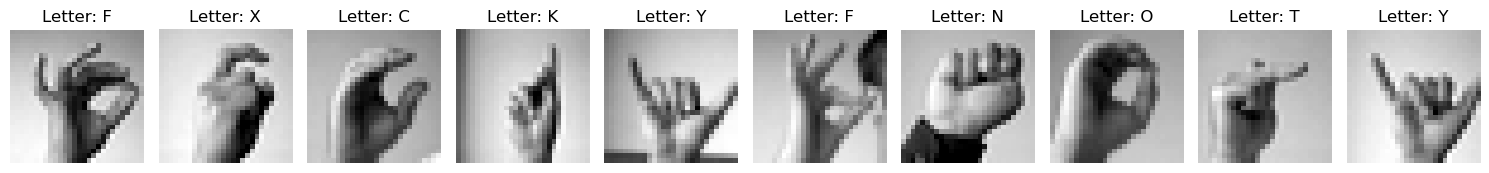


Training neural network...

Network architecture:
Input size: 784
Hidden size: 150
Output size: 24
Iteration 0, Cost: 4.0704, Accuracy: 10.73%
Iteration 1, Cost: 3.9519, Accuracy: 23.13%
Iteration 2, Cost: 3.8171, Accuracy: 28.39%
Iteration 3, Cost: 3.6651, Accuracy: 35.33%
Iteration 4, Cost: 3.5209, Accuracy: 35.97%
Iteration 5, Cost: 3.3878, Accuracy: 37.98%
Iteration 6, Cost: 3.2709, Accuracy: 40.26%
Iteration 7, Cost: 3.1680, Accuracy: 45.19%
Iteration 8, Cost: 3.0770, Accuracy: 48.42%
Iteration 9, Cost: 3.0036, Accuracy: 50.05%
Iteration 10, Cost: 2.9336, Accuracy: 49.52%
Iteration 11, Cost: 2.8758, Accuracy: 53.91%
Iteration 12, Cost: 2.8167, Accuracy: 55.86%
Iteration 13, Cost: 2.7688, Accuracy: 54.88%
Iteration 14, Cost: 2.7191, Accuracy: 56.46%
Iteration 15, Cost: 2.6746, Accuracy: 57.56%
Iteration 16, Cost: 2.6357, Accuracy: 58.68%
Iteration 17, Cost: 2.6044, Accuracy: 59.75%
Iteration 18, Cost: 2.5576, Accuracy: 61.31%
Iteration 19, Cost: 2.5249, Accuracy: 61.17%
Iteration 

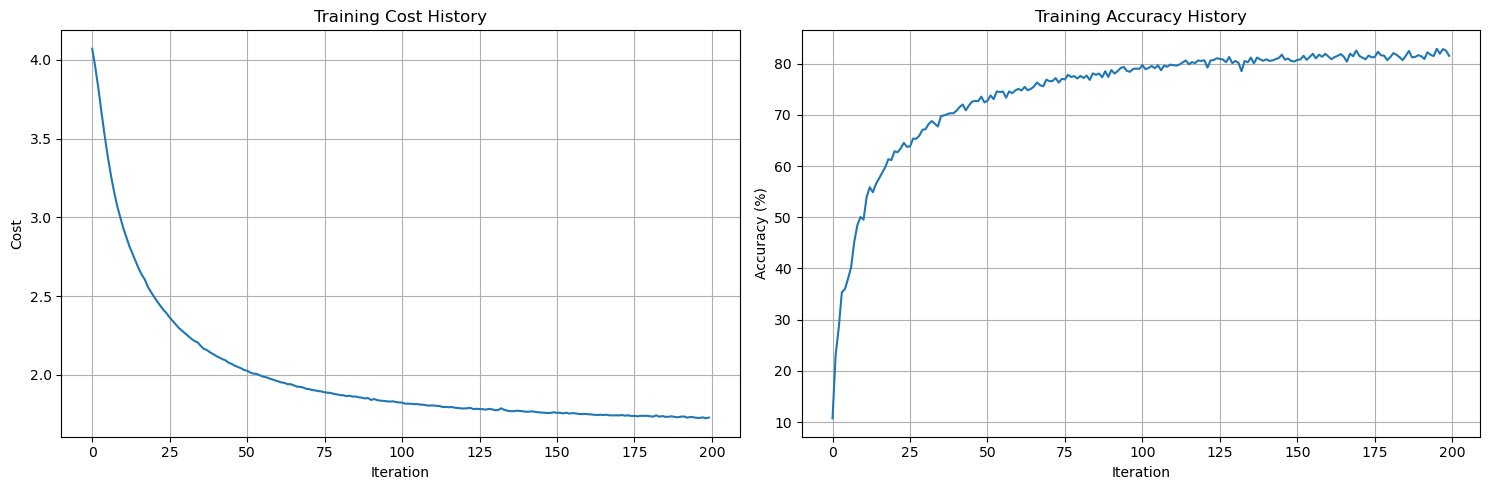


Test Set Accuracy: 66.09%

Model parameters saved to model_parameters.json


In [4]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_and_preprocess_data():
    """
    Load and preprocess the Sign Language MNIST dataset
    Returns normalized features and one-hot encoded labels
    """
    # Load training and test data
    print("Loading datasets...")
    train_data = pd.read_csv('sign_mnist_train.csv')
    test_data = pd.read_csv('sign_mnist_test.csv')

    print("Original shapes:")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Separate features and labels
    X_train = train_data.drop('label', axis=1).values
    y_train = train_data['label'].values
    X_test = test_data.drop('label', axis=1).values
    y_test = test_data['label'].values

    # Normalize pixel values to [0,1]
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Convert labels to one-hot encoding
    def to_one_hot(y, num_classes=24):
        one_hot = np.zeros((y.shape[0], num_classes))
        for i, label in enumerate(y):
            # Adjust labels for J(9) and Z(25) exclusion
            if label > 9:  # After J
                label -= 1
            if label > 24:  # After Z
                label -= 1
            one_hot[i, label] = 1
        return one_hot

    y_train_onehot = to_one_hot(y_train)
    y_test_onehot = to_one_hot(y_test)

    print("\nProcessed shapes:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train_onehot shape: {y_train_onehot.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test_onehot shape: {y_test_onehot.shape}")

    return X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test

def visualize_samples(X, y, num_samples=10):
    """
    Visualize random samples from the dataset
    """
    # Letter mapping (excluding J and Z)
    letters = 'ABCDEFGHIKLMNOPQRSTUVWXY'

    indices = np.random.randint(0, len(y), num_samples)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        # Convert numeric label to letter
        label = y[idx]
        if label > 9:  # After J
            label -= 1
        if label > 24:  # After Z
            label -= 1
        letter = letters[label]
        plt.title(f'Letter: {letter}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def sigmoid(z):
    """
    Compute sigmoid activation function with numerical stability
    """
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_gradient(z):
    """
    Compute gradient of sigmoid function
    """
    s = sigmoid(z)
    return s * (1 - s)

def initialize_weights(input_size, hidden_size, output_size):
    """
    Initialize weights using Xavier initialization
    """
    epsilon_1 = np.sqrt(6) / np.sqrt(input_size + hidden_size)
    epsilon_2 = np.sqrt(6) / np.sqrt(hidden_size + output_size)

    Theta1 = np.random.rand(hidden_size, input_size + 1) * 2 * epsilon_1 - epsilon_1
    Theta2 = np.random.rand(output_size, hidden_size + 1) * 2 * epsilon_2 - epsilon_2

    return Theta1, Theta2

def forward_propagate(X, Theta1, Theta2):
    """
    Perform forward propagation
    """
    m = X.shape[0]

    # Add bias term
    a1 = np.hstack([np.ones((m, 1)), X])

    # Hidden layer
    z2 = np.dot(a1, Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.hstack([np.ones((m, 1)), a2])

    # Output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    return a1, z2, a2, z3, a3

def compute_cost(h, y, Theta1, Theta2, lambda_reg):
    """
    Compute cost with regularization
    """
    m = y.shape[0]
    epsilon = 1e-15

    cost = -1/m * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
    reg_term = (lambda_reg/(2*m)) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))

    return cost + reg_term

def train_neural_network(X, y, y_original, hidden_size=150, lambda_reg=0.1,
                        alpha=0.01, num_iters=200, batch_size=32):
    """
    Train neural network using mini-batch gradient descent
    """
    input_size = X.shape[1]  # 784 for 28x28 images
    output_size = 24  # 24 letters (excluding J and Z)
    m = X.shape[0]

    print(f"\nNetwork architecture:")
    print(f"Input size: {input_size}")
    print(f"Hidden size: {hidden_size}")
    print(f"Output size: {output_size}")

    # Initialize weights
    Theta1, Theta2 = initialize_weights(input_size, hidden_size, output_size)

    # Training history
    cost_history = []
    accuracy_history = []

    for iteration in range(num_iters):
        # Shuffle the data
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        y_original = y_original[indices]

        # Mini-batch processing
        for batch_start in range(0, m, batch_size):
            batch_end = min(batch_start + batch_size, m)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]

            # Forward propagation
            a1, z2, a2, z3, a3 = forward_propagate(X_batch, Theta1, Theta2)

            # Backpropagation
            m_batch = X_batch.shape[0]
            delta3 = a3 - y_batch

            delta2 = np.dot(delta3, Theta2) * np.hstack([np.ones((m_batch, 1)),
                                                        sigmoid_gradient(z2)])
            delta2 = delta2[:, 1:]

            # Compute gradients
            Theta2_grad = (1/m_batch) * np.dot(delta3.T, a2)
            Theta1_grad = (1/m_batch) * np.dot(delta2.T, a1)

            # Add regularization to gradients
            Theta2_grad[:, 1:] += (lambda_reg/m_batch) * Theta2[:, 1:]
            Theta1_grad[:, 1:] += (lambda_reg/m_batch) * Theta1[:, 1:]

            # Update weights
            Theta2 -= alpha * Theta2_grad
            Theta1 -= alpha * Theta1_grad

        # Compute metrics for full dataset
        _, _, _, _, h = forward_propagate(X, Theta1, Theta2)
        cost = compute_cost(h, y, Theta1, Theta2, lambda_reg)
        cost_history.append(cost)

        predictions = np.argmax(h, axis=1)
        accuracy = np.mean(predictions == np.argmax(y, axis=1)) * 100
        accuracy_history.append(accuracy)

        # if iteration % 10 == 0:
        print(f"Iteration {iteration}, Cost: {cost:.4f}, Accuracy: {accuracy:.2f}%")

    return Theta1, Theta2, cost_history, accuracy_history

def plot_training_history(cost_history, accuracy_history):
    """
    Plot training metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot cost history
    ax1.plot(cost_history)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')
    ax1.set_title('Training Cost History')
    ax1.grid(True)

    # Plot accuracy history
    ax2.plot(accuracy_history)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training Accuracy History')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def save_model_parameters(Theta1, Theta2, output_file='model_parameters.json'):
    """
    Save the trained model parameters to a JSON file
    """
    model_params = {
        'Theta1': Theta1.tolist(),
        'Theta2': Theta2.tolist(),
        'input_size': Theta1.shape[1] - 1,
        'hidden_size': Theta1.shape[0],
        'output_size': Theta2.shape[0]
    }

    with open(output_file, 'w') as f:
        json.dump(model_params, f)

    print(f"\nModel parameters saved to {output_file}")

if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, y_train_onehot, y_train, X_test, y_test_onehot, y_test = load_and_preprocess_data()

    # Visualize some samples
    print("\nVisualizing random samples from the training set:")
    visualize_samples(X_train, y_train)

    print("\nTraining neural network...")
    # Train the neural network with adjusted parameters for letter recognition
    Theta1, Theta2, cost_history, accuracy_history = train_neural_network(
        X_train,
        y_train_onehot,
        y_train,
        hidden_size=150,  # Increased for more complex patterns
        lambda_reg=0.1,
        alpha=0.01,
        num_iters=200,
        batch_size=32
    )

    # Plot training history
    plot_training_history(cost_history, accuracy_history)

    # Evaluate on test set
    _, _, _, _, h_test = forward_propagate(X_test, Theta1, Theta2)
    test_predictions = np.argmax(h_test, axis=1)
    test_accuracy = np.mean(test_predictions == np.argmax(y_test_onehot, axis=1)) * 100
    print(f"\nTest Set Accuracy: {test_accuracy:.2f}%")

    # Save the model
    save_model_parameters(Theta1, Theta2)